# 랜덤함수 결과 분포 시각화

In [1]:
import random
import secrets

import numpy as np
import numpy.typing as npt
import pandas as pd
from scipy.stats import chi2
from plotly import express as px

state = 0

def somerand_init(seed: int = 1) -> None:
    global state
    state = seed & 0xffffffff

def somerand_get() -> int:
    global state
    state = (state * 1103515245 + 12345) & 0xffffffff
    return (state // 65536) % 32768

def badrand_get() -> int:
    return somerand_get() % 20000

def chi_square_test(rand : callable) -> tuple[float, npt.NDArray[np.uint32]]:
    bins = np.zeros(32768, dtype=np.uint32)
    sample_num = 1000000
    for _ in range(sample_num):
        bins[rand()] += 1

    # Chi-squared test
    e_i = sample_num / len(bins)  # Expected frequency for each bin
    chi_square = sum((o_i - e_i)**2 / e_i for o_i in bins)
    degrees_of_freedom = len(bins) - 1  # Number of bins - 1
    p_value = chi2.sf(chi_square, degrees_of_freedom)

    return p_value, bins

In [2]:
random.seed(1)
somerand_init(1)

p_random, dist_random = chi_square_test(lambda: random.randrange(32768))
p_secrets, dist_secrets = chi_square_test(lambda: secrets.randbelow(32768))
p_somerand, dist_somerand = chi_square_test(somerand_get)
p_badrand, dist_badrand = chi_square_test(badrand_get)

x = np.arange(len(dist_random))
df = pd.DataFrame({
    'bin': np.tile(x, 4),
    'count': np.concatenate([
        dist_random, dist_secrets, dist_somerand, dist_badrand
    ]),
    'method': (
        ['random.randrange'] * len(x) +
        ['secrets.randbelow'] * len(x) +
        ['somerand_get'] * len(x) +
        ['badrand_get'] * len(x)
    )
})

In [3]:
pd.DataFrame({
    'Method': [
        'random.randrange(32768)',
        'secrets.randbelow(32768)',
        'somerand_get()',
        'badrand_get()'
    ],
    'P-value': [
        p_random,
        p_secrets,
        p_somerand,
        p_badrand
    ]
})

,Method,P-value
0,random.randrange(32768),0.822861
1,secrets.randbelow(32768),0.463866
2,somerand_get(),0.494039
3,badrand_get(),0.000000


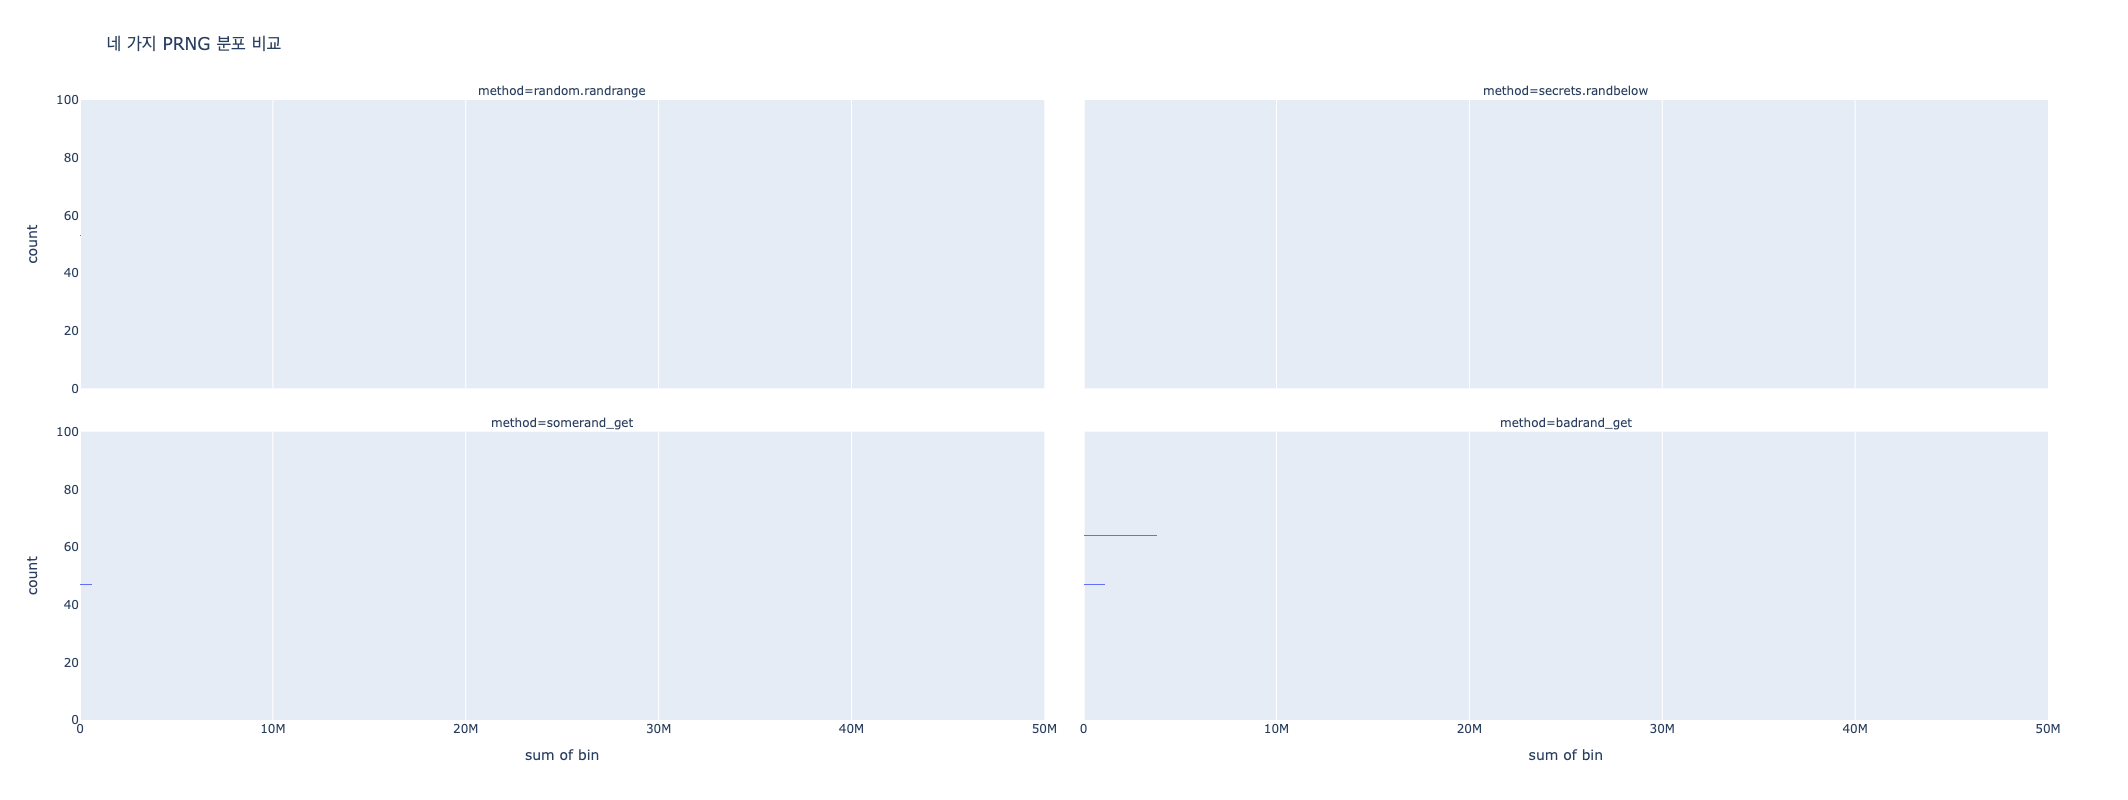

In [4]:
fig = px.histogram(
    df,
    x='bin',
    y='count',
    histfunc='sum', # 같은 bin 값에 대해 'count'를 합산
    facet_col='method',
    facet_col_wrap=2,
    nbins=len(x), # 각 정수값마다 하나의 빈으로 매핑
    title='네 가지 PRNG 분포 비교',
    range_x=[0, 50_000_000],
    range_y=[0, 100],
)
fig.update_layout(
    showlegend=False,
    height=800,
    width=1200
)
fig.show()

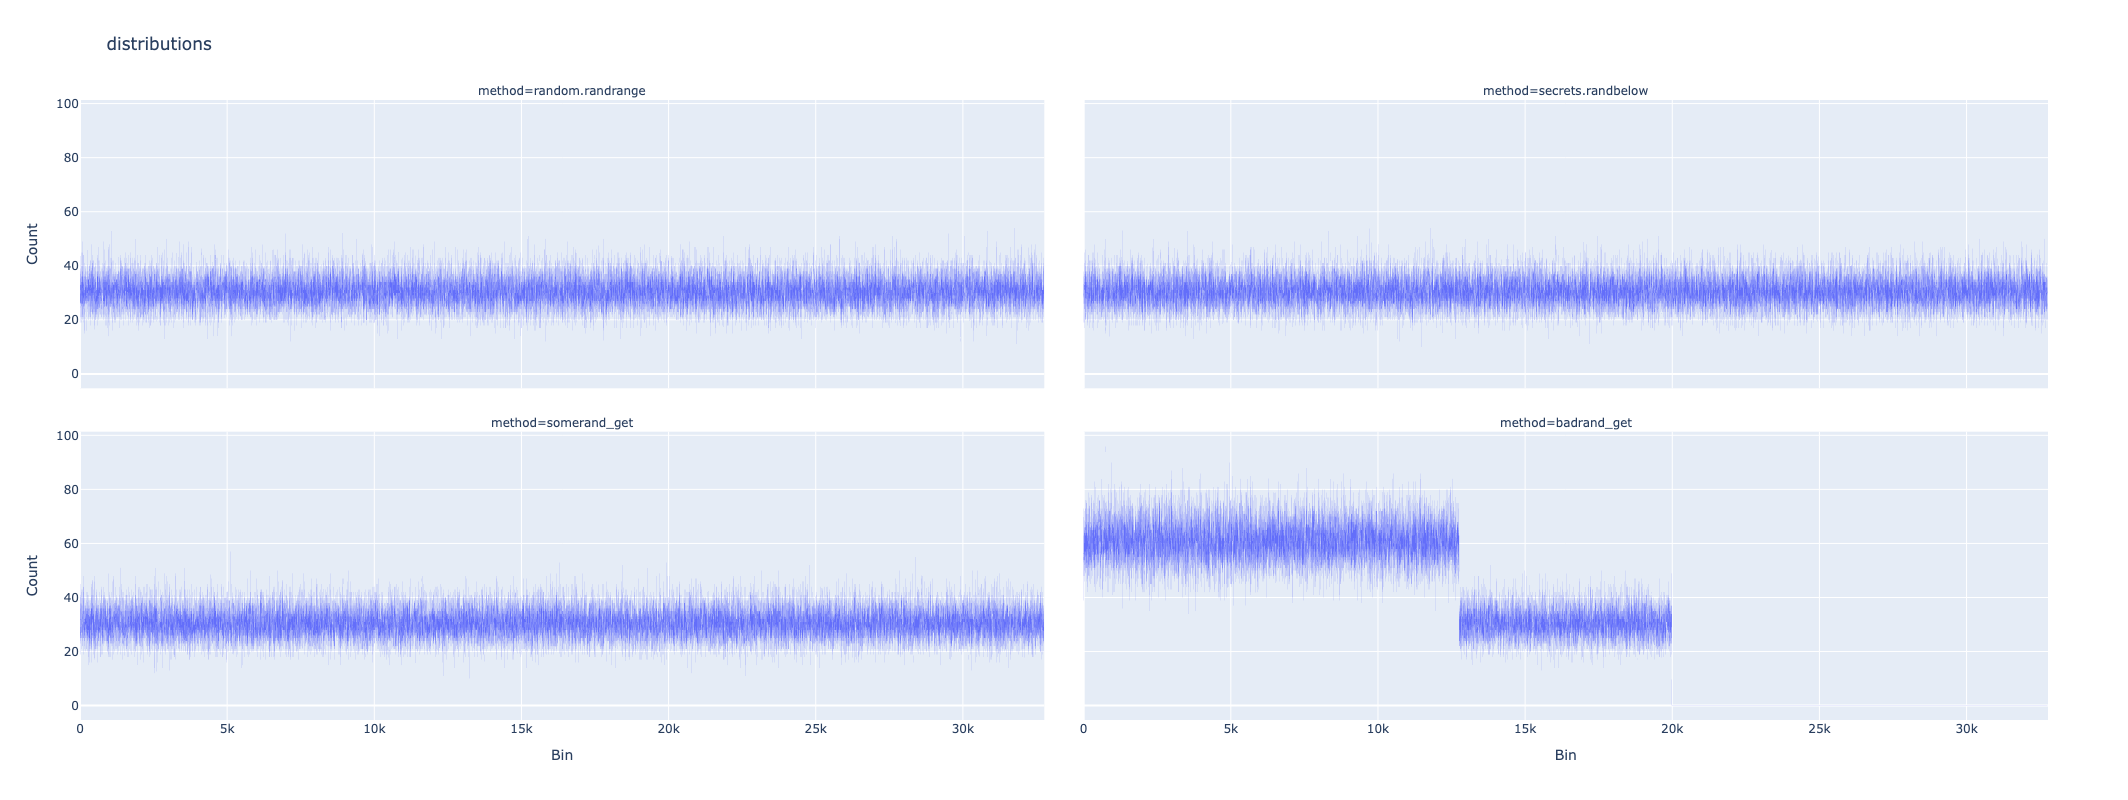

In [5]:
fig = px.line(
    df,
    x='bin',
    y='count',
    facet_col='method',
    facet_col_wrap=2,
    title='distributions',
    labels={'bin':'Bin', 'count':'Count'}
)
fig.update_layout(
    showlegend=False,
    height=800,
    width=1200
)
fig.update_traces(line_width=0.1)
fig.show()